**Stat 542 - Statistical Learning**

**Fall 2022**

**Coding Assignment #4**

**Author: Paolo Furlanetto Ferrari**

**Date: November 3, 2022**

In [116]:
import numpy as np
import numpy.linalg as la
import random
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(3213)

# Part I

## I.I Coding the EM functions

First I will code all the required functions for this part of the Assignment.

i. Gaussian function

In [173]:
def gaussian(x, mu, sigma):
    x = np.array(x)
    mu = np.array(mu)
    sigma = np.array(sigma)
    k = 2
    return np.exp(-0.5*np.matmul(np.matmul((x-mu).T, la.inv(sigma)), x-mu))/np.sqrt(((2*np.pi)**k)*np.abs(la.det(sigma)))

ii. Estep function

In [174]:
def estep(data, G, para):   
    
    prob = para['prob']
    mean = para['mean']
    sigma = para['sigma']   
    N = data.shape[0]
    gamma = np.zeros((N,G))
    
    for i in range(N):
        sum_row = 0
        for k in range(G):
            gamma[i,k] = prob[k]*gaussian(data[i], mean[k], sigma)
            sum_row += gamma[i,k]
        gamma[i,:] = gamma[i,:]/sum_row
    
    return gamma

iii. Mstep function

In [50]:
def mstep(data, G, para, post_prob):
    
    N = data.shape[0]
    n = data.shape[1]
    mean = np.zeros((G, n))
    sigma = np.zeros((n, n))
    prob = np.zeros((G, 1))
    
    for k in range(G):
        mean[k,:] = np.sum((post_prob[:,k].reshape(N,1)*data), axis=0)/np.sum(post_prob[:,k])
        prob[k] = np.sum(post_prob[:,k])/N
        for i in range(N):
            sigma = sigma + (post_prob[i, k]*np.outer((data[i,:] - mean[k,:]),(data[i,:] - mean[k,:])))
        
    sigma = sigma/np.sum(post_prob)    
        
    para['prob'] = prob
    para['mean'] = mean
    para['sigma']  = sigma
    
    return para

iv. Log-likelihood function

In [53]:
def loglik(data, G, para):
    
    N = data.shape[0]
    prob = para['prob']
    mean = para['mean']
    sigma = para['sigma'] 
    prod = 1
    
    for i in range(N):    
        sum_k = 0
        for k in range(G):
            sum_k += gaussian(data[i,:], mean[k,:], sigma)*prob[k]
        prod = prod*sum_k
    
    return prod
    


v. myEM function

In [93]:
def myEM(data, itmax, G, para):
    
    for t in range(itmax):
        post_prob = estep(data, G, para)
        para = mstep(data, G, para, post_prob)
     
    return para

## I.II Results of the EM code to the faithful data

Now I will apply those functions to the "faithful" data.

I obtained the data from R and exported it to a csv file called "data.csv".

In [674]:
df = pd.read_csv("data.csv")
data = np.array(df)
data = data[:,1:]



Let's viualize the data to make sure it is correct.

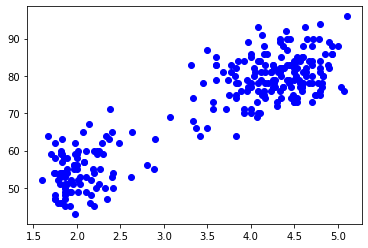

In [675]:
for point in data:
    plt.plot(point[0], point[1], 'bo')

plt.show()

First, let's apply the EM algorith to this data using 2 centers. To do that, let's define the initial covariance matrix, means and probability. I obtained these from running the provided R code in R using my ID seed 3213:

In [729]:
sigma0 = [[1.2740839,13.802511], [13.802511, 183.500211]]
G = 2
para0 = {'prob':[0.49632353, 0.50367647], 'mean':[[3.3321926,70.0888889], [3.6411022,71.6934307]], 'sigma': sigma0}



Then let's run the code for 20 iterations

In [730]:

para_EM = myEM(data, 20, G, para0)
print('Probability of each class:') 
print(para_EM['prob'])

print('Mean of each class:') 
print(para_EM['mean'])

print('Covariance matrix:') 
print(para_EM['sigma'])



Probability of each class:
[[0.49332519]
 [0.50667481]]
Mean of each class:
[[ 3.2881073  69.71486281]
 [ 3.68219792 72.04810692]]
Covariance matrix:
[[  1.25911896  13.69658241]
 [ 13.69658241 182.78305041]]


The results agree with the ones obtained from R by rounding up to the 8 decimal digit.

Now let's do the same procedure for 3 classes (G = 3). First, let's use the initial guesses from R (using seed = 3213):

In [727]:
N = len(data)
sigma0 = [[1.2714837, 13.674284], [13.674284, 181.713589]]
G = 3
para0 = {'prob':[0.35661765, 0.32352941, 0.31985294], 'mean':[[3.5822887,71.5979381], [3.6171818,72.3295455], [3.2515287, 68.6666667]], 'sigma': sigma0}

In [728]:
para_EM = myEM(data, 20, G, para0)
print('Probability of each class:') 
print(para_EM['prob'])

print('Mean of each class:') 
print(para_EM['mean'])

print('Covariance matrix:') 
print(para_EM['sigma'])


Probability of each class:
[[0.3562424 ]
 [0.32431578]
 [0.31944182]]
Mean of each class:
[[ 3.77721492 73.92543896]
 [ 3.77549978 74.2297951 ]
 [ 2.87290131 64.13621459]]
Covariance matrix:
[[  1.1204746   11.97522984]
 [ 11.97522984 162.67309642]]


The results agree with the ones obtained from R by rounding up to the 8 decimal digit.

## I.III EM expressions

Here I will list the expressions without derivations. I have put all derivations on a separate pdf file.

i. Marginal likelihood function:

$$
L(x|p_{1:G},\mu_{1:G},\Sigma) = \Pi_{i=1}^n \Sigma_{k=1}^G p_k N(x_i, \mu_k, \Sigma)
$$

Where $N(x_i, \mu_k, \Sigma)$ is the normal distribution with average $\mu_k$ and covariance matrix $\Sigma$:

$$
N(x_i, \mu_k, \Sigma) = \frac{1}{\sqrt{(2\pi)^k \det(\Sigma)}} \exp[-0.5 (x_i - \mu_k)\Sigma^{-1} (x_i - \mu_k)^T]
$$ 

ii. Complete likelihood function:

$$
L(x, Z|p_{1:G},\mu_{1:G},\Sigma) = \Pi_{i=1}^n \Pi_{k=1}^G p_k [N(x_i, \mu_k, \Sigma)]^{1_{Z_i=k}}
$$

iii. Distribution of Zi at the E-step:

$$
w_{ik} = \frac{p_k N(x_i, \mu_k, \Sigma)}{\Sigma_{l=1}^G p_k N(x_i, \mu_l, \Sigma)}
$$

iv. Objective function of M-step:

$$
O = \Sigma_{i=1}^n \Sigma_{k=1}^G w_{ik} \log{[p_k N(x_i, \mu_k, \Sigma)]}
$$

v.i. Updating formula for $p_{1:G}$

$$
p_k = \frac{\Sigma_{i=1}^n w_{ik}}{n}
$$

v.ii. Updating formula for $\mu_{1:G}$

$$
\mu_k = \frac{\Sigma_{i=1}^n w_{ik}x_i}{\Sigma_{i=1}^n w_{ik}}
$$

v.iii. Updating formula for $\Sigma$

$$
\Sigma = \frac{\Sigma_{k=1}^G\Sigma_{i=1}^n w_{ik}(x_i-\mu_k)(x_i-\mu_k)^T}{\Sigma_{k=1}^G\Sigma_{i=1}^n w_{ik}}
$$

# Part II


## II.I Baum-Welch


Below are the main functions used for the Baum-Welch algorith. First, the alpha coefficients:

In [631]:
def alpha_forward(X, A, B, w):
    
    n = X.shape[0]
    mz = A.shape[0]
    alpha = np.zeros((n, mz))
    
    # First alpha
    alpha[0,:] = w*B[:,int(X[0])]
  
    # Forward loop
    for t in range(1, n):
        for i in range(mz):
            alpha[t, i] = (np.dot(alpha[t-1,:], A[:,i]))*B[i,int(X[t])]
 
    return alpha

Then the beta coefficients

In [632]:
def beta_backward(X, A, B):
    
    n = X.shape[0]
    mz = A.shape[0]
    beta = np.zeros((n, mz))

    # Last beta
    beta[n-1] = np.ones((mz))

    # Backward loop
    for t in range(n-2,-1,-1):
        for i in range(mz):
            beta[t, i] = np.dot(beta[t+1]*B[:,int(X[t+1])], A[i,:])
 
    return beta

Finally the main Baum-Welch algorithm

In [661]:
def baum_welch(X, Ai, Bi, w, itmax):
    
    n = X.shape[0]
    mz = Ai.shape[0]
    mx = Bi.shape[1]
    gamma = np.zeros((n-1, mz, mz))
    gamma_t = np.zeros((n-1, mz))
    
    Ao = np.array(Ai)
    Bo = np.array(Bi)
    
    for it in range(itmax):
        
        alpha = alpha_forward(X, Ao, Bo, w)
        beta = beta_backward(X, Ao, Bo)   
        
        for i in range(mz):
            for j in range(mz):
                for t in range(n-1):
                    gamma[t,i,j] = alpha[t,i]*Ao[i,j]*Bo[j,int(X[t+1])]*beta[t+1,j]
        
        for i in range(mz):
            for t in range(n-1):
                gamma_t[t,i] = np.sum(gamma[t,i,:])
        
        
        for i in range(mz):
            for j in range(mz):
                Ao[i,j] = np.sum(gamma[:,i,j])
            
            Ao[i,:] = Ao[i,:]/np.sum(gamma_t[:,i])
            
        for i in range(mz):
            for l in range(mx):
                Bo[i,l] = 0
                for t in range(n-1):
                    inc = (int(X[t])==int(l))*(gamma_t[t,i])
                    Bo[i,l] = Bo[i,l] + inc
            Bo[i,:] = Bo[i,:]/np.sum(gamma_t[:,i])
    
    return Ao, Bo

Now let's import the data and define the initial variables obtained from R:

In [693]:
X = np.ndarray.flatten(np.array((pd.read_csv('part2.csv')))) -1
X = np.concatenate(([1.], X))

w = [0.5, 0.5]
A = 0.5*np.ones((2,2))
B = np.array([[0.1111111, 0.33333333, 0.55555556], [0.16666667, 0.33333333, 0.50000000]])


Let's the run the Baum-Welch code for 1 iteration:

In [697]:
A1, B1 = baum_welch(X, A, B, w, 1)
print('A matrix')
print(A1)

print('B matrix')
print(B1)

A matrix
[[0.48546499 0.51453501]
 [0.48503178 0.51496822]]
B matrix
[[0.23611488 0.19158446 0.57230066]
 [0.33386427 0.18059908 0.48553665]]


For 1 iteration, the output agrees exactly with the one generated from R.

However, for larger steps, my code deviates from the one in R. After 100 iterations, the matrices are slightly different. The results are shown below.

In [714]:
A100, B100 = baum_welch(X, A, B, w, 100)
print('A matrix')
print(A100)

print('B matrix')
print(B100)

A matrix
[[0.51302636 0.48697364]
 [0.45845992 0.54154008]]
B matrix
[[0.2248657  0.19189372 0.58324058]
 [0.34441473 0.18031276 0.47527252]]


I think the reason for this discrepancy is some numerical approximation done differently in Python and in R.

In [701]:
Br = np.array([[0.22159897, 0.20266127, 0.57573976],
     [0.34175148, 0.17866665, 0.47958186]])

Ar = np.array([[0.49793938, 0.50206062],
    [0.44883431, 0.55116569]])

## II.II Viterbi algorithm

First, let's define the delta coefficients

In [706]:
def delta_viterbi(X, A, B, w):
    
    n = X.shape[0]
    mz = A.shape[0]
    delta = np.zeros((n, mz))

    # First delta
    delta[0,:] = w*B[:, int(X[0])]

    # Loop forward
    for t in range(1, n):
        for i in range(mz):
            delta[t,i] = np.max(delta[t-1,:]*A[:,i])*B[i,int(X[t])]

    return delta


And the main Viterbi algorithm

In [709]:
def viterbi(X, A, B, w):
    
    n = X.shape[0]
    mz = A.shape[0]
    Z = np.zeros((n))

    delta = delta_viterbi(X, A, B, w) 

    Z[n-1] = np.argmax(delta[n-1,:])

    
    for t in range(n-2,-1,-1):
        Z[t] = np.argmax(delta[t,:]*A[:, int(Z[t+1])])

    return Z

Let's first run the Viterbi algorithm using the obtained A and B from R:

In [716]:
Zr = viterbi(X, Ar, Br, w)
print(Zr)


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0.]


The sequence agrees exactly with the one from R by the coding A = 0 and B = 1.

Now let's run the Viterbi algorithm on the A and B on my code:

In [717]:
Zp = viterbi(X, A100, B100, w)
print(Zp)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0.]


Even though the A and B matrices are slighlty different, the reconstructed sequences are almost the same!

The fraction of same Z in both sequences is 97.5%!

In [722]:
print('Fraction of same Z =', np.sum(Zr==Zp)/len(Zp))

Fraction of same Z = 0.975
